In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive/GAN/Shipibo GAN/")
!ls

!ls preproc/32/

KeyboardInterrupt: ignored

In [0]:

""" ONly run this the first time to unzip dataset into individual images for easy access from drive
!mkdir imgs_32
!unzip -q preproc/32/0_compressed_32.zip -d imgs_32/
"""

mkdir: cannot create directory ‘imgs_32’: File exists


In [0]:
from keras.preprocessing.image import load_img,img_to_array
from PIL import Image

def load_images(path,size=32):
    """ loads images into a numpy array and returns them
    """
    img_paths = [path + f  for f in os.listdir(path)]
    print(len(img_paths))
    dataset_shape = (len(img_paths),size,size,3)

    data = np.ndarray(shape=dataset_shape)

    for i,f in enumerate(os.listdir(path)):
        im = Image.open(path + f)
        
        im = np.array(im)
        
        if i % 500 == 0:
            print("loaded ", i,"images" )

        data[i] = im.astype(int)
        

    print(data.shape)

    return data
data = load_images("imgs_32/")


loaded  5500 images
loaded  6000 images
loaded  6500 images
loaded  7000 images
loaded  7500 images
loaded  8000 images
loaded  8500 images
loaded  9000 images
loaded  9500 images
loaded  10000 images
loaded  10500 images
loaded  11000 images
loaded  11500 images
loaded  12000 images
loaded  12500 images
loaded  13000 images
loaded  13500 images
loaded  14000 images
loaded  14500 images
loaded  15000 images
loaded  15500 images
loaded  16000 images
loaded  16500 images
loaded  17000 images
loaded  17500 images
loaded  18000 images
loaded  18500 images
loaded  19000 images
loaded  19500 images
loaded  20000 images
loaded  20500 images
loaded  21000 images
loaded  21500 images
loaded  22000 images
loaded  22500 images
loaded  23000 images
loaded  23500 images
loaded  24000 images
(24479, 32, 32, 3)
24479
loaded  0 images
loaded  500 images
loaded  1000 images
loaded  1500 images
loaded  2000 images
loaded  2500 images
loaded  3000 images
loaded  3500 images
loaded  4000 images
loaded  45

In [0]:
#warning, only run this once or else load the data all over again
data = (data - 127.5) / 127.5



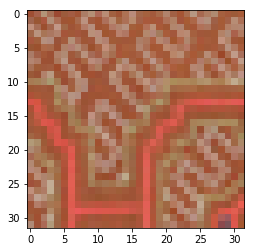

In [0]:
test = (data[0] + 1) / 2.0
plt.imshow(test)

In [0]:
def generate_real_samples(data,n_samples):
    
    rand_indexes = np.random.randint(0,data.shape[0],n_samples)
    
    X_samples = data[rand_indexes]
    y_samples = np.ones((n_samples,1))
    
    return X_samples,y_samples

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.optimizers import Adam

def make_discriminator(input_shape=(32,32,3)):
    
    model = Sequential()
    #normal layer
    model.add(Conv2D(64,(3,3),padding="same",input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    #downsample
    model.add(Conv2D(128,(3,3),strides=(2,2),padding="same"))
    
    model.add(LeakyReLU(alpha=0.2))
    
    #downsample
    model.add(Conv2D(128,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    
    #downsample
    model.add(Conv2D(256,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    #keep this comented for 32x32 version
    #downsample
    # model.add(Conv2D(256,(3,3),strides=(2,2),padding="same"))
    # model.add(LeakyReLU(alpha=0.2))
    
    #flatten then pass through fully connected layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation="sigmoid"))
    
    opt = Adam(lr=0.0002,beta_1=0.5)
    
    model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
    
    return model

In [0]:
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

# define the standalone generator model
def make_generator(latent_dim=100):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #upsample to 64x64
    # model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    # model.add(LeakyReLU(alpha=0.2))
    
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model


In [0]:
def generate_latent_points(n_samples,latent_dim=100):
    
    latent_points = np.random.randn(latent_dim*n_samples)
    
    latent_points = latent_points.reshape((n_samples,latent_dim))
    
    return latent_points

def generate_fake_samples(generator,n_samples,latent_dim=100):
    
    #first generate latent points, then pass them to the generator
    
    latent_points = generate_latent_points(n_samples,latent_dim)
    
    X_fake = generator.predict(latent_points)
    
    y_fake = np.zeros((n_samples,1))
    
    return X_fake,y_fake

In [0]:
def make_gan(discriminator,generator):
    
    model = Sequential()
    
    discriminator.trainable = False
    
    model.add(generator)
    
    model.add(discriminator)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy",optimizer=opt)
    
    return model


In [0]:
import time

def train_gan(data,gan,discriminator,generator,n_epochs=200,batch_size=128):
    batch_per_epoch = int(data.shape[0] / batch_size)
    half_batch = int(batch_size / 2)

    print(batch_per_epoch)
    
    n_points = 9
    fixed_latent_points = generate_latent_points(n_points)
    train_images = []
    
    gan_loss = []
    disc_loss = []
    
    
    for epoch in range(n_epochs):
        print("starting epoch",epoch)
        start_time = time.time()
        
        avg_epoch_disc_loss= []
        avg_epoch_gen_loss = []

        for batch in range(batch_per_epoch):
            
            #train the discriminator
            X_real,y_real = generate_real_samples(data,half_batch)
            X_fake,y_fake = generate_fake_samples(generator,half_batch)
            
            X,y = np.vstack((X_real,X_fake)) , np.vstack((y_real, y_fake))
            
            d_loss, _ = discriminator.train_on_batch(X,y)
            
            #train the generator (through the gan model by using the discriminator's error)
            lat_points = generate_latent_points(batch_size)
            y_gan = np.ones((batch_size,1))
            
            g_loss = gan.train_on_batch(lat_points,y_gan)
            
            
            #paint some pictures
            if batch % 10 == 0:
                imgs = generator.predict(fixed_latent_points)

                #renormalize images for easy printing
                imgs = (imgs + 1) / 2.0
                train_images.append(imgs)
                
                #add loss to storage for graphing
                
                gan_loss.append(g_loss)
                disc_loss.append(d_loss)
            
            avg_epoch_disc_loss.append(d_loss)
            avg_epoch_gen_loss.append(g_loss)

        stop_time = time.time()
        print("avg loss over epoch, \nDiscriminator:" ,sum(avg_epoch_disc_loss)/len(avg_epoch_disc_loss),"\nGenerator:",sum(avg_epoch_gen_loss)/len(avg_epoch_gen_loss))
        print("epoch",epoch,"finished in",stop_time - start_time,"s\n\n")
            
            
    return train_images,gan_loss,disc_loss


reset_train = False

if reset_train:    
    discriminator = make_discriminator()
    generator = make_generator()

    gan = make_gan(discriminator,generator)



train_images,gan_loss,disc_loss = train_gan(data,gan,discriminator,generator,n_epochs=100)            
            
     

191
starting epoch 0


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


avg loss over epoch, 
Discriminator: 0.19427898740737226 
Generator: 3.9121955576991536
epoch 0 finished in 32.95364284515381 s


starting epoch 1
avg loss over epoch, 
Discriminator: 0.18478557307526702 
Generator: 3.9631886319964345
epoch 1 finished in 32.86712193489075 s


starting epoch 2
avg loss over epoch, 
Discriminator: 0.1890594707655657 
Generator: 3.7390929104770043
epoch 2 finished in 32.95105051994324 s


starting epoch 3
avg loss over epoch, 
Discriminator: 0.20047482298150737 
Generator: 3.7904945056475894
epoch 3 finished in 32.855769872665405 s


starting epoch 4
avg loss over epoch, 
Discriminator: 0.19782309593018438 
Generator: 3.620629942229905
epoch 4 finished in 32.82361197471619 s


starting epoch 5
avg loss over epoch, 
Discriminator: 0.17784915482186522 
Generator: 3.620127076253841
epoch 5 finished in 32.869789838790894 s


starting epoch 6
avg loss over epoch, 
Discriminator: 0.19622823432165915 
Generator: 3.645545939500419
epoch 6 finished in 32.844735622

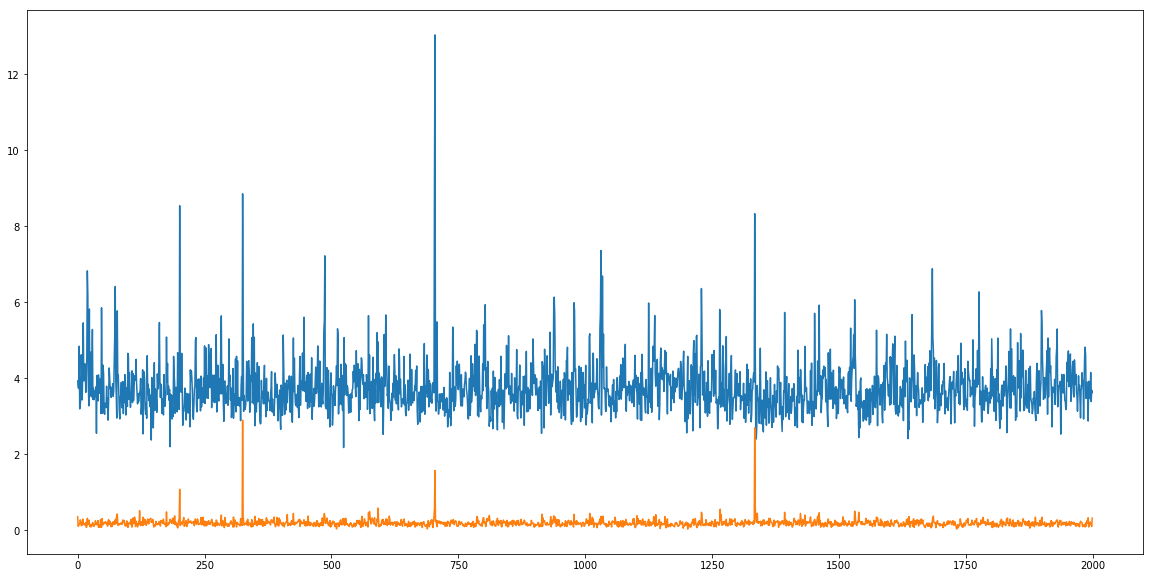

In [0]:
plt.figure(figsize=(20,10))

plt.plot(gan_loss)
plt.plot(disc_loss)

plt.show()

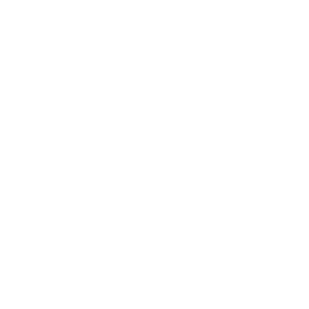

In [0]:
from matplotlib import animation

ims = []
fig = plt.figure()
ax = fig.add_axes([0,0,1,1], frameon=False, aspect=1)
ax.set_xticks([]); ax.set_yticks([])

for train_ims in train_images:

    

    im_1 = plt.imshow(train_ims[0,:,:],vmin=0, vmax=1, animated=True) #add first image for test
    
    ims.append([im_1])
    #plt.pause(0.1) 

mp4_writer =  animation.writers['ffmpeg']
writer = mp4_writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)


anim = animation.ArtistAnimation(fig,ims)
anim.save("test_gif_2.mp4", writer= writer)

(3, 3)


KeyboardInterrupt: ignored

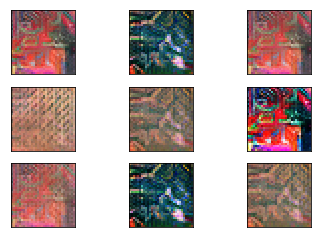

In [0]:
fig,axs = plt.subplots(3,3)

print(axs.shape)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

images = []

#iterate ove images
for imgs in train_images:
    ims = [] 
    for i,img in enumerate(imgs):
        
        line = i%3
        col = int(i/3)
        ims.append(axs[line,col].imshow(img[:,:],vmin=0, vmax=1, animated=True))
    
    images.append(ims)

mp4_writer =  animation.writers['ffmpeg']
writer = mp4_writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)

anim = animation.ArtistAnimation(fig,images)
anim.save("train_grid.mp4", writer= writer)


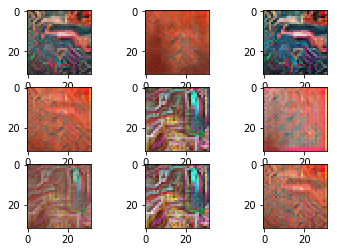

In [0]:
points = generate_latent_points(9)
im_pred = generator.predict(points)
im_pred = (im_pred+1) /2.0

for i,im in enumerate(im_pred):
    plt.subplot(3,3,i+1)
    plt.imshow(im)

plt.show()